<a href="https://colab.research.google.com/github/ereny123/Multitasking-MThesis-2024/blob/main/Pytorch_NET_Singletask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [ ]:
#create a model class
class Model(nn.Module):
  #Input (Tasks) random array of 9 units
  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer

    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    # print("Task Hidden Weight Shape:", self.task_hidden.weight.shape)
    # print("Task Output Weight Shape:", self.task_out.weight.shape)
    # print("Stimulus Hidden Weight Shape:", self.stim_hidden.weight.shape)
    # print("Hidden Output Weight Shape:", self.hidden_out.weight.shape)

    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act
    print("h_act shape:", h_act.shape)
    print("out_act shape:", out_act.shape)

#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break

            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log



# Using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()

    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [ ]:
# Generate training data
def generate_dataset_singletask():
  stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *20 , dtype=torch.float)


# Generate task data
  taskDatapattern = torch.tensor([
     [1, 0, 0, 0, 0, 0, 0, 0, 0] , #Task 1
     [0, 1, 0, 0, 0, 0, 0, 0, 0] , #Task 2
     [0, 0, 1, 0, 0, 0, 0, 0, 0] , #Task 3
     [0, 0, 0, 1, 0, 0, 0, 0, 0] , #Task 4
     [0, 0, 0, 0, 1, 0, 0, 0, 0] , #Task 5
     [0, 0, 0, 0, 0, 1, 0, 0, 0] , #Task 6
     [0, 0, 0, 0, 0, 0, 1, 0, 0] , #Task 7
     [0, 0, 0, 0, 0, 0, 0, 1, 0] , #Task 8
     [0, 0, 0, 0, 0, 0, 0, 0, 1] ]  #Task 9


                          , dtype=torch.float)

  taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern])


  targetData = torch.zeros((540,9), dtype=torch.float)

  for i in range(len(targetData)):
     if taskData[i, :3].sum() > 0:
         targetData[i, :3] = stimulusData[i, :3]
     elif taskData[i, 3:6].sum() > 0:
         targetData[i, 3:6] = stimulusData[i, 3:6]
     elif taskData[i, 6:].sum() > 0:
         targetData[i, 6:] = stimulusData[i, 6:]

  # for i in range(len(targetData)):
  #   for j in range(0, len(targetData[i]), 3):
  #       if taskData[i, j:j+3].sum() > 0:
  #           targetData[i, j:j+3] = stimulusData[i, j:j+3]



  return stimulusData, taskData, targetData


In [ ]:
stimulusData, taskData, targetData = generate_dataset_singletask()

IndexError: index 243 is out of bounds for dimension 0 with size 243

In [ ]:
print(targetData[50:60])
print(taskData[50:60])

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.]])
tensor([[1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.]])


In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(taskData, stimulusData)

(tensor([[0.0762, 0.1036, 0.1462,  ..., 0.1233, 0.1003, 0.1455],
         [0.0786, 0.1040, 0.1486,  ..., 0.1186, 0.1034, 0.1521],
         [0.0783, 0.1192, 0.1499,  ..., 0.1229, 0.1126, 0.1489],
         ...,
         [0.0986, 0.1189, 0.1472,  ..., 0.1287, 0.1151, 0.1604],
         [0.0909, 0.1038, 0.1421,  ..., 0.1266, 0.1066, 0.1543],
         [0.0906, 0.1189, 0.1434,  ..., 0.1312, 0.1160, 0.1510]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1019, 0.1440, 0.1028,  ..., 0.1240, 0.1222, 0.1191],
         [0.1011, 0.1435, 0.1032,  ..., 0.1239, 0.1225, 0.1198],
         [0.1014, 0.1438, 0.1034,  ..., 0.1244, 0.1223, 0.1200],
         ...,
         [0.0882, 0.1134, 0.1011,  ..., 0.1370, 0.0969, 0.1312],
         [0.0877, 0.1122, 0.1006,  ..., 0.1360, 0.0960, 0.1307],
         [0.0878, 0.1124, 0.1008,  ..., 0.1365, 0.0958, 0.1308]],
        grad_fn=<SigmoidBackward0>))

In [ ]:
print("Size of taskData:", taskData.size())
print("Size of stimulusData:", stimulusData.size())
print("Size of trainData:", targetData.size())


# print("Size of taskData:", taskData_m.size())
# print("Size of stimulusData:", stimulusData_m.size())
# print("Size of trainData:", trainData_m.size())

Size of taskData: torch.Size([540, 9])
Size of stimulusData: torch.Size([540, 9])
Size of trainData: torch.Size([540, 9])


In [ ]:
MSE_log = trainOnline(model, stimulusData, taskData, targetData, 100000)

100%|██████████| 100000/100000 [08:22<00:00, 198.95it/s, MSE=0.0027]


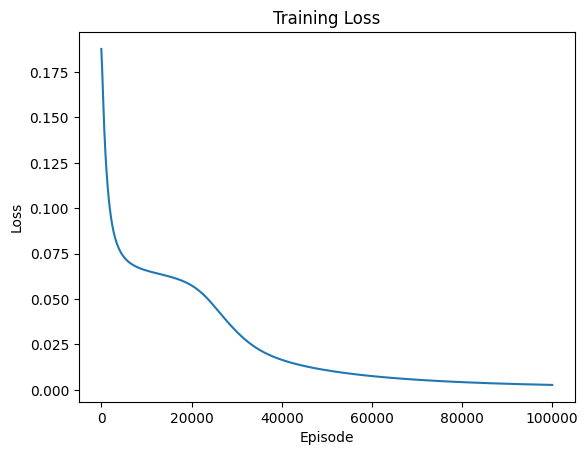

In [ ]:
single_log=plot_losses(MSE_log)

Episode 1/1000 | Loss: 876.39
Episode 2/1000 | Loss: 868.09
Episode 3/1000 | Loss: 859.92
Episode 4/1000 | Loss: 851.88
Episode 5/1000 | Loss: 843.98
Episode 6/1000 | Loss: 836.22
Episode 7/1000 | Loss: 828.60
Episode 8/1000 | Loss: 821.13
Episode 9/1000 | Loss: 813.80
Episode 10/1000 | Loss: 806.62
Episode 11/1000 | Loss: 799.59
Episode 12/1000 | Loss: 792.72
Episode 13/1000 | Loss: 785.99
Episode 14/1000 | Loss: 779.41
Episode 15/1000 | Loss: 772.97
Episode 16/1000 | Loss: 766.68
Episode 17/1000 | Loss: 760.53
Episode 18/1000 | Loss: 754.51
Episode 19/1000 | Loss: 748.62
Episode 20/1000 | Loss: 742.85
Episode 21/1000 | Loss: 737.19
Episode 22/1000 | Loss: 731.64
Episode 23/1000 | Loss: 726.19
Episode 24/1000 | Loss: 720.82
Episode 25/1000 | Loss: 715.53
Episode 26/1000 | Loss: 710.31
Episode 27/1000 | Loss: 705.16
Episode 28/1000 | Loss: 700.05
Episode 29/1000 | Loss: 694.99
Episode 30/1000 | Loss: 689.97
Episode 31/1000 | Loss: 684.99
Episode 32/1000 | Loss: 680.03
Episode 33/1000 |

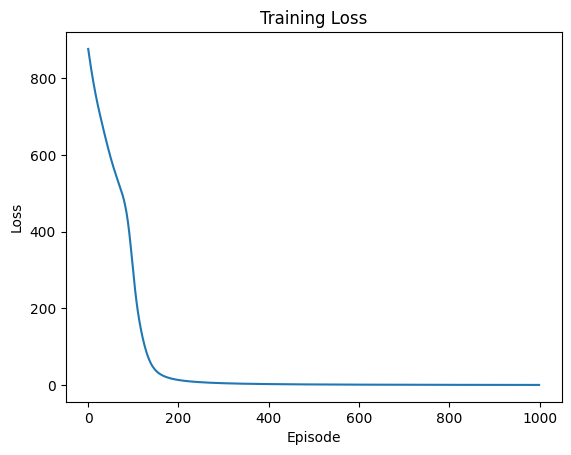

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define training loop
def train_Rein(num_episodes=1000, log_interval=1):
    losses = []  # To store losses at each episode
    for episode in range(1, num_episodes + 1):

        # Forward pass
        _, outputs = model(taskData, stimulusData)

        # Define reward
        reward = torch.sum(outputs * targetData)

        # Train using REINFORCE
        loss = reinforce_train(model, optimizer, taskData, stimulusData, reward)
        losses.append(loss)
        #Logging
        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.2f}")
    plot_losses(losses)
# Train the model
train_Rein()